In [38]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 


In [18]:
df = pd.read_csv("../Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
targetColumns = list(df.columns[1:4]) + list(df.columns[5:19]) + list(df.columns[21:22])
load = df[targetColumns].iloc[7247:8687].values
data = np.ravel(load)

realLoads = np.empty((18,30,48))
for day in range(realLoads.shape[1]):
    for hour in range(realLoads.shape[2]):
        for feeder in range(realLoads.shape[0]):
            realLoads[feeder][day][hour] = data[day*realLoads.shape[0]*realLoads.shape[2] + hour*realLoads.shape[0] + feeder]


In [19]:
load_data = np.loadtxt("forecastData.txt")
filter_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

In [20]:
load_data = np.loadtxt("scheduleData.txt")
schedule_data = load_data.reshape(load_data.shape[0], load_data.shape[1] // 48, 48)

newLoad = np.empty((18,30,48))
SOC = np.empty((18,30,48))
chargeRate = np.empty((18,30,48))
for feeder in range(SOC.shape[0]):
    for day in range(SOC.shape[1]):
        for hour in range(SOC.shape[2]):
            newLoad[feeder][day][hour] = schedule_data[feeder*newLoad.shape[1] + day][5][hour]
            SOC[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][0][hour]
            chargeRate[feeder][day][hour] = schedule_data[feeder*SOC.shape[1] + day][1][hour] - schedule_data[feeder*SOC.shape[1] + day][2][hour] 

d:\Programs\Python\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


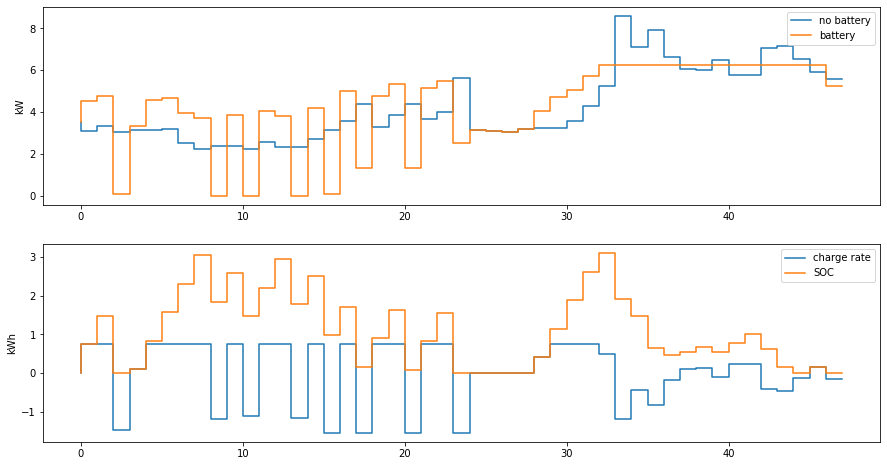

In [21]:
y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].step(y,filter_data[0][1], label="no battery")
axs[0].step(y,newLoad[0][1], label="battery")
axs[0].legend()
axs[0].set_ylabel("kW")

axs[1].step(y,chargeRate[0][1], label="charge rate")
axs[1].step(y,SOC[0][1],label="SOC")
axs[1].legend()
axs[1].set_ylabel("kWh")


fig.set_figheight(8)
fig.set_figwidth(15)
fig.show()

In [22]:
load_data = np.loadtxt("forecastData.txt")
peakLoad = np.amax(load_data, axis=0)

class Battery:
    def __init__(self, maxLoad, chargeEfficiency=0.95, dischargeEfficiency=0.95):
        self.maxSOC = maxLoad * 0.25                    # in kWh
        self.maxChargeRate = (maxLoad * 0.25) / 2       # in kW
        self.maxDischargeRate = maxLoad * 0.25          # in kW
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency


batteries = []
for i in range(filter_data.shape[0]):
    batteries.append(Battery(peakLoad[i]))

In [23]:
newSOC = np.empty((18,30,48))
newChargeRate = np.empty((18,30,48))
gridImport = np.empty((18,30,48))

for feeder in range(newSOC.shape[0]):
    for day in range(newSOC.shape[1]):
        for hour in range(newSOC.shape[2]):
            if hour == 0:
                newChargeRate[feeder][day][hour] = 0
                newSOC[feeder][day][hour] = 0
            else:
                newSOC[feeder][day][hour] = newSOC[feeder][day][hour-1] + chargeRate[feeder][day][hour]
                if newSOC[feeder][day][hour] > batteries[feeder].maxSOC:
                    # Assume extra charge is simply wasted
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
                    newSOC[feeder][day][hour] = batteries[feeder].maxSOC
                elif newSOC[feeder][day][hour] < 0:
                    # Charge less than zero must be accounted for
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour] - newSOC[feeder][day][hour]
                    newSOC[feeder][day][hour] = 0
                else:
                    newChargeRate[feeder][day][hour] = chargeRate[feeder][day][hour]
            
            gridImport[feeder][day][hour] = realLoads[feeder][day][hour] + 2*newChargeRate[feeder][day][hour]


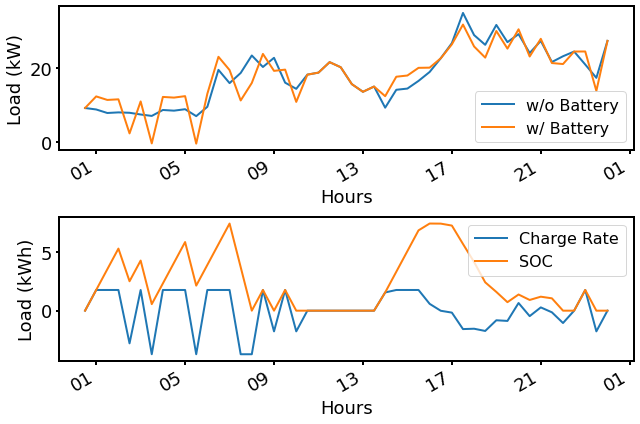

In [88]:
feeder = 9
day = 3

fig, axs = plt.subplots(2)
axs[0].plot(df["Timestamp"].iloc[0:48],realLoads[feeder][day], label="w/o Battery", linewidth=2)
axs[0].plot(df["Timestamp"].iloc[0:48],gridImport[feeder][day], label="w/ Battery", linewidth=2)
axs[0].set_ylabel("Load (kW)", fontsize=18)
axs[0].set_xlabel("Hours", fontsize=18)
axs[0].legend(prop={'size': 16})

axs[1].plot(df["Timestamp"].iloc[0:48],newChargeRate[feeder][day], label="Charge Rate", linewidth=2)
axs[1].plot(df["Timestamp"].iloc[0:48],newSOC[feeder][day],label="SOC",linewidth=2)
axs[1].set_ylabel("Load (kWh)", fontsize=18)
axs[1].set_xlabel("Hours", fontsize=18)
axs[1].legend(prop={'size': 16})


for ax in axs:
  xloc = mdates.HourLocator(interval=4)
  ax.xaxis.set_major_locator(xloc)
  #ax.grid(True)
  # Set labels to day number - month name
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
  # Rotates and right-aligns the x labels so they don't crowd each other.
  for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.tick_params(width=2)
  

#fig.legend(loc=2, bbox_to_anchor=(0.13,0.98), prop={'size': 16})


fig.set_figheight(6)
fig.set_figwidth(9)

plt.tight_layout()
plt.savefig("battery_schedule.svg", format='svg', dpi=1500, bbox_inches="tight")
plt.show()

In [25]:
peakChangeRatio = []

for feeder in range(gridImport.shape[0]):
    realLoadsMax = []
    batteryLoadsMax = []
    for day in range(gridImport.shape[1]):
        realLoadsMax.append(max(realLoads[feeder][day]))
        batteryLoadsMax.append(max(gridImport[feeder][day]))
    peakChangeRatio.append(np.mean(np.divide(batteryLoadsMax, realLoadsMax)))

peakChangeRatio = np.asarray(peakChangeRatio)

# Value > 1 means peak is decreasing, < 1 means peak is increasing
percentageReduction = (1-peakChangeRatio) * 100
np.mean(percentageReduction)

2.324385526944243

In [26]:
np.argmax(peakChangeRatio)
print(max(peakChangeRatio))

print(max(realLoads[3][25]) / max(gridImport[3][25]))

1.0214445840877053
1.0
